In [1]:
import matplotlib.pyplot as plt
import static_nda as nda
import datajoint as dj
import numpy as np
import cv2
import pandas as pd
from copy import deepcopy
from matplotlib import colors
from skimage import feature
from pipeline import meso, collection
anat = dj.create_virtual_module('anatomy', 'pipeline_anatomy')
maps = dj.create_virtual_module('maps','pipeline_map')

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [2]:
# scan_keys = nda.Scan # scans considered for release, including duplicates
scan_keys = nda.ScanInclude.proj() # scans included in release

In [3]:
ret_df = []
for scan_key in scan_keys:    
    animal_rest = f'animal_id = {scan_key["animal_id"]}'
    ret_rest = 'study_name = "imagenet_V1" and scan_purpose LIKE "%%ret%%"'
    wide_rest = 'notes LIKE "%%3000x3000%%"'

    # find widefield retinotopic mapping scan from curated scans
    wide_ret_key = collection.CuratedScan & animal_rest & ret_rest & wide_rest

    # find manual area annotation from widefield scan
    ret_idx_rel = dj.U('animal_id','ret_idx') & (maps.RetMapScan & wide_ret_key)
    ret_idx_rel = ret_idx_rel & f'ret_idx={max(ret_idx_rel.fetch("ret_idx"))}'
    
    # find manual area annotation from widefield scan applied to widefield scan
    mask_rel = anat.AreaMask & ret_idx_rel & wide_ret_key
    
    # find a scan field from the middle of the group
    ret_z_rel = dj.U('animal_id').aggr(meso.ScanInfo.Field & mask_rel,mean_ret_z = 'AVG(z)')
    scan_field_key = (((meso.ScanInfo.Field & scan_key) * 
                   ret_z_rel).proj(z_diff = 'ABS(z-mean_ret_z)')).fetch('KEY',order_by='z_diff ASC',limit=1)[0]

    # fetch and normalize the functional scan average image
    f_av_im = (meso.SummaryImages.Average & scan_field_key).fetch1('average_image').copy()
    f_av_im -= np.nanpercentile(f_av_im,0.1)
    f_av_im /= np.nanpercentile(f_av_im,99.9)
    f_av_im = np.clip(f_av_im,0,1)

    # functional scan half height, half width
    hh,hw = (np.array(np.shape(f_av_im))/2).astype(int)

    # fetch and normalize the retinotopic scan average image
    r_av_im = np.hstack((meso.SummaryImages.Average *
                      (meso.ScanInfo.Field & mask_rel)).fetch('average_image',order_by='x ASC'))
    r_av_im -= np.nanpercentile(r_av_im,0.1)
    r_av_im /= np.nanpercentile(r_av_im,99.9)
    r_av_im = np.clip(r_av_im,0,1)
    
    # save copy of original retinotopic average image
    orig_r_av_im = deepcopy(r_av_im)
    orig_r_av_im = np.flip(orig_r_av_im.T)
    
    # fetch dimensions of fields of both scans in pixels and microns
    r_pxh,r_pxw,r_umh,r_umw = (dj.U('px_height','px_width','um_height','um_width') & 
                               (meso.ScanInfo.Field & mask_rel)).fetch1().values()
    f_pxh,f_pxw,f_umh,f_umw = (dj.U('px_height','px_width','um_height','um_width') & 
                               (meso.ScanInfo.Field & scan_field_key)).fetch1().values()

    # check that both functional and ret scans have all fields at same resolution
    r_res = list(set((r_pxh/r_umh,r_pxw/r_umw)))
    f_res = list(set((f_pxh/f_umh,f_pxw/f_umw)))
    assert len(r_res) == len(f_res) == 1

    # calculate relative resolution between functional and ret scans
    pxpitch = f_res[0]/r_res[0]

    # resize the retinotopic image to match functional scan resolution
    r_av_im = cv2.resize(r_av_im,tuple((np.array(np.shape(r_av_im))*pxpitch).astype(int)[::-1]),
                               interpolation = cv2.INTER_AREA)
    r_av_im = np.clip(r_av_im,0,1)

    # normalized correlation of functional scan to retinotopic template at each possible pixel offset
    align_mat = feature.match_template(r_av_im,f_av_im,pad_input=True)

    # remove correlations where functional scan is at least half off the retinotopic image
    align_mask = np.zeros_like(align_mat)
    align_mask[hh:-hh,hw:-hw] = 1
    align_mat = align_mat * align_mask

    # find position of maximum correlation
    cy,cx = np.unravel_index(np.argmax(align_mat),np.array(np.shape(r_av_im)).astype(int))

    # crop to aligned location in retinotopic scan
    aligned_r_av_im = np.pad(r_av_im[np.max((cy-hh,0)):np.min((cy+hh,np.shape(r_av_im)[0])),
                                     np.max((cx-hw,0)):np.min((cx+hw,np.shape(r_av_im)[1]))],
                            ((-np.min((cy-hh,0)),-np.min((np.shape(r_av_im)[0]-(cy+hh),0))),
                             (-np.min((cx-hw,0)),-np.min((np.shape(r_av_im)[1]-(cx+hw),0)))))


#     # initialize alignment visualization
#     fig,axes = plt.subplots(1,3,figsize=(15,10))

#     # plot functional scan in red
#     rgba_im = np.zeros((*np.shape(f_av_im),4))
#     rgba_im[:,:,0] = f_av_im
#     rgba_im[:,:,-1] = 1

#     axes[0].imshow(rgba_im)
#     axes[0].set_title('func_'+'_'.join([str(s) for s in list(scan_key.values())[:3]]),fontsize=20)

#     # plot functional scan in red and aligned location in retinotopic scan in green
#     rgba_im = np.zeros((*np.shape(f_av_im),4))
#     rgba_im[:,:,0] = f_av_im
#     rgba_im[:,:,1] = aligned_r_av_im
#     rgba_im[:,:,-1] = 1
#     axes[1].imshow(rgba_im)
#     axes[1].set_title('coregistration',fontsize=20)

#     # plot aligned retinotopic scan only in green
#     rgba_im = np.zeros((*np.shape(f_av_im),4))
#     rgba_im[:,:,1] = aligned_r_av_im
#     rgba_im[:,:,-1] = 1
#     axes[2].imshow(rgba_im)
#     axes[2].set_title('ret_'+'_'.join([str(s) for s 
#                                        in list((wide_ret_key & mask_rel).fetch1('KEY').values())[1:4]]),
#                       fontsize=20)


#     plt.show()
#     plt.close()
    
    nan_im = np.full((r_pxh,len(meso.ScanInfo.Field & mask_rel) * r_pxw),np.nan)

    field_atts = ['x','px_width','um_width']
    area_masks,bas,xs,pws,uws = ((mask_rel & 'brain_area != "unknown"') * 
                                 meso.ScanInfo.Field).fetch('mask','brain_area',*field_atts)
    xs = xs * pws / uws # convert x to pixels
    xs -= np.min(xs - pws/2) # translate so leftmost boundary is pixel 0
    xs = np.round(xs).astype(int)

    m_hws = np.round(pws/2).astype(int)

    mask_outlines = np.full((len(area_masks),*np.shape(nan_im)),0)
    for mask_outline,area_mask,x,m_hw in zip(mask_outlines,area_masks,xs,m_hws):
        mask_outline[:,x-m_hw:x+m_hw] = area_mask

    area_outlines = []
    for brain_area in sorted(list(set(bas))):
        if np.sum(bas==brain_area)>1:
            area_outlines.append(np.max(mask_outlines[bas==brain_area,:,:],axis=0))
        else:
            area_outlines.append(mask_outlines[bas==brain_area].squeeze())
            
    # close holes in masks
    area_outlines = [cv2.morphologyEx(area_outline.astype(np.float32), cv2.MORPH_CLOSE, np.ones((5, 5)))
                     for area_outline in area_outlines]
    # remove floater pixels
    area_outlines = [cv2.morphologyEx(area_outline.astype(np.float32), cv2.MORPH_OPEN, np.ones((5, 5))) 
                     for area_outline in area_outlines]
    
    # save unflattened masks
    area_masks = np.array(deepcopy(area_outlines))
    area_masks[area_masks==0] = np.nan
    area_masks = np.flip(np.moveaxis(area_masks,1,2),axis=(1,2))
    
    # find outlines of masks
    area_outlines = [cv2.morphologyEx(area_outline.astype(np.float32), cv2.MORPH_GRADIENT, np.ones((5, 5))) 
                     for area_outline in area_outlines]
    
    # flatten all outlines into single layer
    area_outline = np.nanmax(area_outlines,axis=0)
    area_outline[area_outline == 0] = np.nan
    
    # create mask for imaging ROI, resize to retinotopic resolution
    roi_mask = np.zeros_like(r_av_im)
    roi_mask[np.max((cy-hh,0)):np.min((cy+hh,np.shape(r_av_im)[0])),
             np.max((cx-hw,0)):np.min((cx+hw,np.shape(r_av_im)[1]))] = 1
    roi_mask = cv2.resize(roi_mask,np.shape(nan_im)[::-1])
    roi_mask = cv2.morphologyEx(roi_mask.astype(np.float32),cv2.MORPH_GRADIENT,np.ones((5,5)))
    roi_mask[roi_mask==0] = np.nan
    roi_mask[roi_mask>0] = 1

    # transform from top/bottom/left/right as LMPA to APML
    area_outline = np.flip(area_outline.T)
    roi_mask = np.flip(roi_mask.T)
    
    ret_df.append({'scan_key':scan_key,
                   'ret_key':(dj.U('animal_id','session','scan_idx') & mask_rel).fetch1('KEY'),
                   'brain_areas':sorted(list(set(bas))),
                   'area_masks':area_masks,
                   'area_outline':area_outline,
                   'roi_mask':roi_mask,
                   'r_av_im':orig_r_av_im,
                   'r_res':r_res})
ret_df = pd.DataFrame(ret_df)

#     fig,ax = plt.subplots(figsize=(5,5))
#     ax.imshow(area_outline,cmap='binary_r',interpolation='none')
#     ax.imshow(roi_mask,cmap='binary_r',interpolation='none')
#     ax.set_aspect('equal')
    
    
#     plt.show()
#     plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys


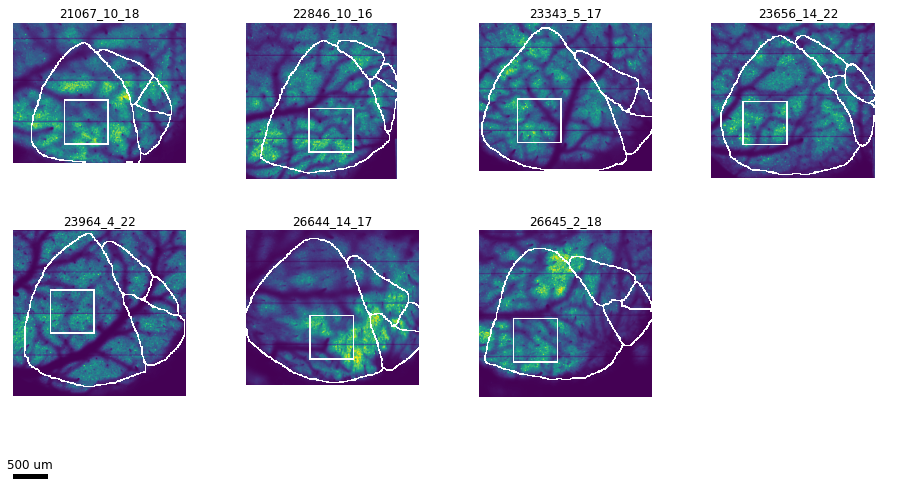

In [6]:
fig,axes = plt.subplots(2,4,figsize=(16,7))
axes = axes.flatten()
for (_,r),ax in zip(ret_df.iterrows(),axes):
    w = 250
#     cy,cx = np.round(np.mean(np.where(~np.isnan(r.area_masks[[ba=='V1' for ba in r.brain_areas]].squeeze())),
#                              axis=1)).astype(int)
    cy,cx = np.round(np.mean(np.where(~np.isnan(np.nanmax(r.area_masks,axis=0))),
                             axis=1)).astype(int)

    
    
    
    ax.imshow(np.pad(r.r_av_im[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
                               np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
                     ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
                      (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
                     constant_values=np.nan))
    ax.imshow(np.pad(r.area_outline[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
                                    np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
                     ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
                      (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
                     constant_values=np.nan),
              cmap='binary',interpolation='none')
    ax.imshow(np.pad(r.roi_mask[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
                                np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
                     ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
                      (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
                     constant_values=np.nan),
              cmap='binary',interpolation='none')
    ax.set_aspect('equal')
    ax.set_title('_'.join([str(s) for s in r.scan_key.values()]))
    
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# target length of scale bar in microns
length = 500

# shared pixel / micron resolution across all subplots
res_set = set(np.concatenate(ret_df['r_res']))
assert len(res_set) == 1, 'more than one resolution present'
res = list(res_set)[0]

# width of each subplot in pixels
subplot_width = 2*w

# fraction of the figure occupied by each subplot and x offset of first figure
ax_x0,_,ax_w,ax_h = axes[0].get_position().bounds

bar_width = length * res / subplot_width * ax_w
bar_height = 0.025 * ax_h

ax = fig.add_axes((ax_x0,-0.025,bar_width,bar_height), facecolor='none')
ax.imshow(np.ones((2,2)),cmap='binary_r',aspect='auto')
ax.set_axis_off()
_ = ax.set_title(str(int(length)) + ' um')

# plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: All-NaN slice encountered
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered


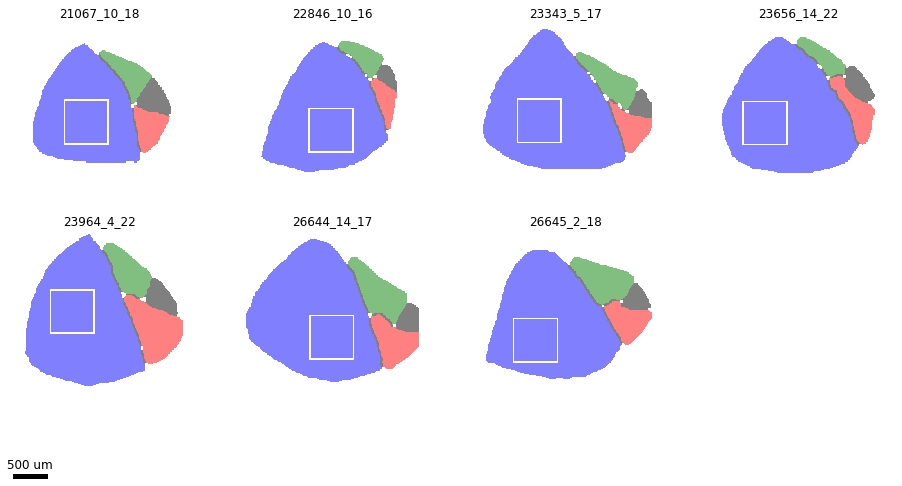

In [7]:
fig,axes = plt.subplots(2,4,figsize=(16,7))
axes = axes.flatten()
for (_,r),ax in zip(ret_df.iterrows(),axes):
    w = 250
#     cy,cx = np.round(np.mean(np.where(~np.isnan(r.area_masks[[ba=='V1' for ba in r.brain_areas]].squeeze())),
#                              axis=1)).astype(int)
    cy,cx = np.round(np.mean(np.where(~np.isnan(np.nanmax(r.area_masks,axis=0))),
                             axis=1)).astype(int)

    area_outlines = []
    for area_mask,c in zip(r.area_masks,['k','r','g','b']):
        area_mask = np.pad(area_mask[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
                                     np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
                         ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
                          (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
                           constant_values=np.nan)
        area_mask = area_mask[:,:,None] * np.array(colors.to_rgba(c))[None,None,:]
        area_mask[:,:,-1] *= 0.5
        area_outlines.append(area_mask)
        
    area_outline = np.nanmax(area_outlines,axis=0)
    area_outline[area_outline == 0] = np.nan
    
    ax.imshow(area_outline)
    
        
    
    
    
#     ax.imshow(np.pad(r.r_av_im[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
#                                np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
#                      ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
#                       (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
#                      constant_values=np.nan))
#     ax.imshow(np.pad(r.area_outline[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
#                                     np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
#                      ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
#                       (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
#                      constant_values=np.nan),
#               cmap='binary',interpolation='none')
    ax.imshow(np.pad(r.roi_mask[np.max((cy-w,0)):np.min((cy+w,np.shape(r.r_av_im)[0])),
                                np.max((cx-w,0)):np.min((cx+w,np.shape(r.r_av_im)[1]))],
                     ((-np.min((cy-w,0)),-np.min((np.shape(r.r_av_im)[0]-(cy+w),0))),
                      (-np.min((cx-w,0)),-np.min((np.shape(r.r_av_im)[1]-(cx+w),0)))),
                     constant_values=np.nan),
              cmap='binary',interpolation='none')
    ax.set_aspect('equal')
    ax.set_title('_'.join([str(s) for s in r.scan_key.values()]))
    
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# target length of scale bar in microns
length = 500

# shared pixel / micron resolution across all subplots
res_set = set(np.concatenate(ret_df['r_res']))
assert len(res_set) == 1, 'more than one resolution present'
res = list(res_set)[0]

# width of each subplot in pixels
subplot_width = 2*w

# fraction of the figure occupied by each subplot and x offset of first figure
ax_x0,_,ax_w,ax_h = axes[0].get_position().bounds

bar_width = length * res / subplot_width * ax_w
bar_height = 0.025 * ax_h

ax = fig.add_axes((ax_x0,-0.025,bar_width,bar_height), facecolor='none')
ax.imshow(np.ones((2,2)),cmap='binary_r',aspect='auto')
ax.set_axis_off()
_ = ax.set_title(str(int(length)) + ' um')
